In [1]:
import os
import numpy as np
import cv2
import pandas as pd

# utils imports
import scipy.io as sio
import math
from math import cos, sin

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms
import torchvision
import torch.utils.model_zoo as model_zoo

import matplotlib.pyplot as plt

from PIL import Image, ImageFilter

In [18]:
torch.cuda.is_available()

True

# Utils

In [2]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    with open(file_path) as f:
        lines = f.read().splitlines()
    return lines

In [3]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    #print(f'this is the mat file fot sample {mat_path} : {mat}')
    pt2d = mat['pt2d']
    return pt2d

In [4]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [5]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [6]:
def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

In [7]:
# ceate filesname file for dataset calss
def filter_samples(mat_path):
    '''
    neglect the samples with angel outside the angles range [-99, 99]
    paramters
    ---------
    mat_path : str, path for sample mat file that contains angel informations
    '''
    pose = get_ypr_from_mat(mat_path)
    pitch = pose[0] * 180 / np.pi
    yaw = pose[1] * 180 / np.pi
    roll = pose[2] * 180 / np.pi

    valid = (np.abs(pitch) > 99 or
           np.abs(yaw) > 99 or
           np.abs(roll) > 99)

    return valid

def find_filenams(imgs_folder, filename_path, img_ext = '.jpg'):
    '''
    create file with the names of the training samples for 300W_LP dataset
    '''
    with open(f'{filename_path}/filename_list.txt', 'w') as names_file:
        valid_samples = 0
        for img_name in os.listdir(imgs_folder) :
            # not image
            if not img_name.endswith(img_ext): continue 
            annot_path = f'{imgs_folders}/{img_name.replace(".jpg",".mat")}'
            # check tha angle range 
            if filter_samples(annot_path): continue
            # save the sample
            names_file.write(f'{img_name.replace(".jpg","")}\n')
            valid_samples += 1
                
        print(f'number of valid samples is {valid_samples}')

In [11]:
'''# creat the filenmae for 300W_LP Dataset without flipping dataset
imgs_folders = '../dataset/AFLW2000'
filename_path = imgs_folders
find_filenams(imgs_folders, filename_path)'''

number of valid samples is 1969


# DataSet

In [8]:

class AFLW2000(Dataset):
    def __init__(self, data_dir, filename_path, transform, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.transform = transform
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(filename_path)

        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.data_dir, self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.data_dir, self.y_train[index] + self.annot_ext)

        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels = torch.LongTensor(np.digitize([yaw, pitch, roll], bins) - 1)
        cont_labels = torch.FloatTensor([yaw, pitch, roll])

        if self.transform is not None:
            img = self.transform(img)

        return img, labels, cont_labels, self.X_train[index]

    def __len__(self):
        # 2,000
        return self.length

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3) <class 'numpy.ndarray'>


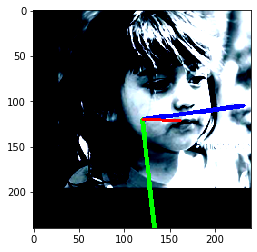

In [12]:
# test AFLW2000 Dataset Class
transformations = transforms.Compose([transforms.Scale(224),
                                      transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = AFLW2000(data_dir = '../dataset/AFLW2000', filename_path = '../dataset/AFLW2000/filename_list.txt', transform = transformations)
dl = DataLoader(dataset, batch_size=1, shuffle=True)

for img, dig_labels, exact_labels, img_path in dl:
    img, dig_labels, exact_labels, img_path = img[0], dig_labels[0], exact_labels[0], img_path[0]
    # draw the head pose estimation axes
    image = img.permute((1,2,0)).numpy()
    image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
    #image = cv2.imread(os.path.join('dataset/300W_LP', img_path + '.jpg'))
    print(image.shape, type(image))
    draw_axis(image, exact_labels[0], exact_labels[1], exact_labels[2], 
              tdx = image.shape[1] / 2, tdy= (image.shape[0]) / 2, size = image.shape[0]/2)
    plt.imshow(image)
    break

# Arch

In [13]:
class Hopenet(nn.Module):
    # Hopenet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll

# Test

In [25]:
batch_size = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

checkpoints_file = 'checkpoints'
last_checkpoint = f'{checkpoints_file}/headpose_last.pth'
best_checkpoint = f'{checkpoints_file}/headpose_best.pth'
best_checkpoint_acc = f'{checkpoints_file}/headpose_best_acc.pth'
# dataset variables
data_dir = '../dataset/AFLW2000'
filename_list = f'{data_dir}/filename_list.txt'

# checkpoint to test
test_checkpoint = last_checkpoint

output = f'output'
# create checkpoints file
os.makedirs(output, exist_ok=True)

save_out = True
disp_every = 100

In [15]:
# Intialize dataset calss
transformations = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_dataset = AFLW2000(data_dir , filename_list, transform = transformations)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# intialize model
# ResNet50 structure
model = Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
model.to(device)
softmax = nn.Softmax(dim=1).to(device)

In [17]:
# load checkpoint
check = torch.load(test_checkpoint)
model.load_state_dict(check['state_dic'])

<All keys matched successfully>

In [19]:
def get_reg_form_cls(pred, prop_func, device):
    # compute predected prop
    pred_prop = softmax(pred)
    # get regression value for proplities
    idx_tensor = torch.FloatTensor([idx for idx in range(66)]).to(device)
    reg_pred = torch.sum(pred_prop * idx_tensor, dim=1) * 3 - 99 # [-99, 99]
    return reg_pred

In [30]:
def Test_HeadPose(model, prop_func, test_loader, disp_every, save_out, device):
    
    model.eval()
    
    # values to compute
    yaw_error = .0
    pitch_error = .0
    roll_error = .0
    test_size = len(test_loader.dataset)
    
    for i, (img, bins_angles, angles, img_name) in enumerate(test_loader):
        
        # load to device 
        img = img.to(device)
        angles = angles.to(device)
        bins_angles = bins_angles.to(device)
        
        with torch.no_grad():
            # pass image to the model
            pred_yaw, pred_pitch, pred_roll = model(img)
        
        # get the regression values for the output of the model
        reg_yaw = get_reg_form_cls(pred_yaw, prop_func, device)
        reg_pitch = get_reg_form_cls(pred_pitch, prop_func, device)
        reg_roll = get_reg_form_cls(pred_roll, prop_func, device)
        
        # compute Accuracy
        yaw_error += torch.sum(torch.abs(reg_yaw - angles[:, 0])).cpu().detach().numpy()
        pitch_error += torch.sum(torch.abs(reg_pitch - angles[:, 1])).cpu().detach().numpy()
        roll_error += torch.sum(torch.abs(reg_roll - angles[:, 2])).cpu().detach().numpy()
        
        # print results and save to logger
        if i % disp_every == 0:
            print(f'Processing in Itr[{i}/{len(test_loader)}')
        
        # save the prediction of the firest image in the batch
        if save_out:
            name = img_name[0]
            cv2_img = cv2.imread(os.path.join(data_dir, name + '.jpg'))
            # the error in the img prediction
            error_string = 'y %.2f, p %.2f, r %.2f' % (torch.abs(reg_yaw[0] - angles[0,0])
                                                           , torch.abs(reg_pitch[0] - angles[0,1])
                                                           , torch.abs(reg_roll[0] - angles[0,2]))
            # save the error in the image
            cv2.putText(cv2_img, error_string, (30, cv2_img.shape[0]- 30), fontFace=1, 
                        fontScale=1, color=(0,0,255), thickness=2)
            # utils.plot_pose_cube(cv2_img, yaw_predicted[0], pitch_predicted[0], roll_predicted[0], size=100)
            draw_axis(cv2_img, reg_yaw[0], reg_pitch[0], reg_roll[0], 
                      tdx = 200, tdy= 200, size=100)
            cv2.imwrite(os.path.join(f'{output}', name + '.jpg'), cv2_img)
            
            
    # finish test
    yaw_error /= test_size
    pitch_error /= test_size
    roll_error /= test_size
    
    # the output string
    print(f'the final total error in degrees in {test_size} smaples.\n\
    Yaw:{yaw_error:.2f}, Pitch:{pitch_error:.2f}, Roll:{roll_error:.2f}')
    
    return yaw_error, pitch_error, roll_error

In [31]:
# test AFLW2000 Dataset

yaw_error, pitch_error, roll_error = Test_HeadPose(model, softmax, test_loader, disp_every, save_out, device)

Processing in Itr[0/1969
Processing in Itr[100/1969
Processing in Itr[200/1969
Processing in Itr[300/1969
Processing in Itr[400/1969
Processing in Itr[500/1969
Processing in Itr[600/1969
Processing in Itr[700/1969
Processing in Itr[800/1969
Processing in Itr[900/1969
Processing in Itr[1000/1969
Processing in Itr[1100/1969
Processing in Itr[1200/1969
Processing in Itr[1300/1969
Processing in Itr[1400/1969
Processing in Itr[1500/1969
Processing in Itr[1600/1969
Processing in Itr[1700/1969
Processing in Itr[1800/1969
Processing in Itr[1900/1969
the final total error in degrees in 1969 smaples.
    Yaw:6.85, Pitch:7.47, Roll:5.80
